In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

#device: llevar todos los tensores al GPU
# definimos el dispositivo que vamos a usar para el entrenamiento
# el GPU con 'cuda' o si no un 'CPU' extra
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# hiper parametros
input_size = 784 # (28x28) imágenes
num_classes = 10 #cantidad de imágenes número diferentes | labels 1, 2, ..., 9
num_epochs = 5 
batch_size_train = 64 #cada cuántos ejemplos vamos a iterar en train
batch_size_test = 1000 #cada cuántos ejemplos vamos a iterar en test
momentum = 0.9 # valor de optimización
log_interval = 100 #imprimir los valores del entrenamiento cada 100 iteraciones
learning_rate = 0.001

# MNIST dataset: conjunto de imágenes de números escritos a mano
# Objetivo: identificar qué número es cada una 
# cada una de las imágenes es de 28x28x1 (recordar es 1 por escala de grises)

#descarga los datos

# descargamos la data y a la vez indicando que transforme ('transform') la data
# la transformación se da para convertir a Tensor y ejecutar un proceso de normalización
# la normalización usada es de media y desviación estándar típica
train_dataset = torchvision.datasets.MNIST(root='data',
                  train=True, 
                  transform=transforms.Compose([transforms.ToTensor(), #normalize convierte de -1 a 1
                                                transforms.Normalize((0.5,),(0.5,))]),  
                  download=True)

# aqui se hace la carga pero no de entrenamiento 
# por ello se pone 'TRAIN = FALSE'
test_dataset = torchvision.datasets.MNIST(root='data', 
                  train=False,
                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))

# Data loader 
# Crea los bach:
# The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
# Armado de dataset por pytorch
# Carga de imágenes en el GPU
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True) #shuffle chocolatea las imágenes

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=False)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Batch size** is a term used in machine learning and refers to the number of training examples utilized in one iteration. 

In [ ]:
#print(train_dataset[0][0].shape) #dimension del tensor
#print(train_dataset[0]) # tupla(0 => tensor, 1 => label)
# print(train_dataset[0][0].shape) # dimension del tensor
#print(f'label = {train_dataset[0][1]}') # label para esta primera imagen '1'

print(len(train_loader)) # nro de batches

print(len(train_dataset))

print(938*64) 

#en el ultimo batch solo habria poco menos de 64 datos
#de ese modo se corresponden los tamaños
#recordemos que los bach son fracciones del training set

938
60000
60032


Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


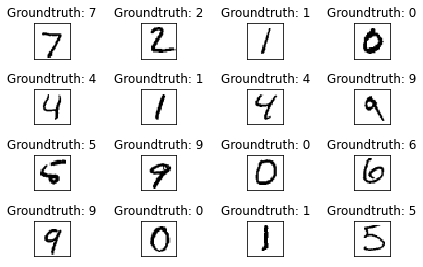

In [ ]:
examples = enumerate(test_loader) # Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) # Obtenemos el siguiente batch como EJEMPLO usando 'Next'
#batch elegido
print(f'Numero de batch: {batchId}')
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

# Mostramos los primeros 16 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray_r', interpolation='none')
  plt.title(f'Groundtruth: {exampleTargets[i]}')
  plt.xticks([])
  plt.yticks([])

plt.show()

Vemos la red que vamos a desarrollar:

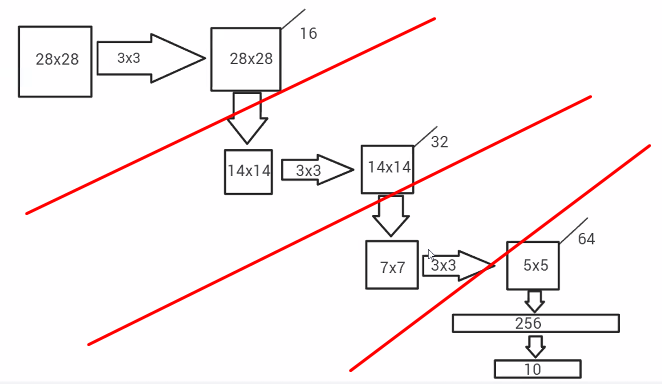

El 28x28, 14x14 se mantienen dado que hemos usado padding. En los otros (paso de 7x7 a 5x5) cambia dado que no hemos usado padding. 

El '5x5' final debemos convertirlo a un arreglo lineal. 

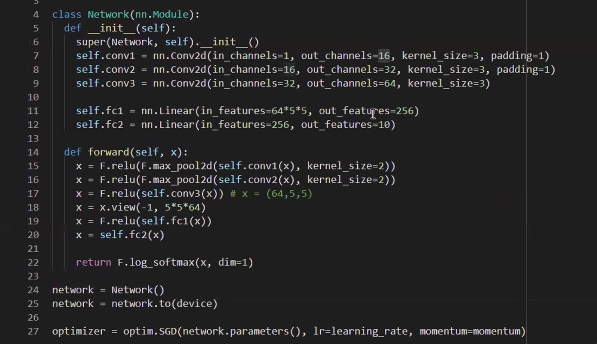

In [ ]:
# Aqui definimos la red neuronal
# ...

#empezamos con la clase
#nn.Module hereda los datos 
class Network(nn.Module):
  def  __init__(self):
    super(Network, self).__init__()
    #crearemos una red de tres capas para extracción de características de nuestro modelo
        
    #primera capa: 'in channels' es 1 debido a que solo recibimos de entrada 1 imagen de 28x28
    #               ese '16' dice que vamos a crear 16 filtros/kernels de 3x3 (kernel_size=3)
    #               La forma más sencilla de entender esto es '16' "features map" o mapa de caracteristicas
    #               Ponemos un padding de 1 para evitar que la imagen pierda su estructura 28x28
    self.conv1 = nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=3, padding=1)
    #segunda capa: note como ahora el 'in_channel' es la salida de la anterior
    self.conv2 = nn.Conv2d(in_channels=16, out_channels = 32, kernel_size=3, padding=1)
    #tercerca capa:
    self.conv3 = nn.Conv2d(in_channels=32, out_channels = 64, kernel_size=3)

    #creamos una capa densa para extraer las caracetrísticas logradas con la red anterior

    #el in_features es 64 dada la salida anterior pero x5x5 
    #ahora ya vamos a empezar a resumir la informacion es decir no ir agrandando mas neuronas
    self.fc1 = nn.Linear(in_features=64*5*5, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=10)

  def forward(self, x):
    #definimos el forward propagation

    #definimos el pooling: 
    #Pooling is nothing other than down sampling of an image. 
    # The most common pooling layer filter is of size 2x2

    #MAX POOLING
    x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
    x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
    x = F.relu(self.conv3(x)) # x = cuyo size es (64, 5, 5) | VER EN LA IMAGEN AL FINAL
    x = x.view(-1, 5*5*64) #usamos los componentes finales de la F.Relu anterior
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    #retornamos la UNICA dimension deseada()
    return F.log_softmax(x, dim=1)

network = Network()
network = network.to(device)

optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
import torchsummary as ts

print(network)

#cuales son las dimensiones de una muestra
ts.summary(network, (1,28,28))

Network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 14, 14]           4,640
            Conv2d-3             [-1, 64, 5, 5]          18,496
            Linear-4                  [-1, 256]         409,856
            Linear-5                   [-1, 10]           2,570
Total params: 435,722
Trainable params: 435,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Param

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs+1)]

# Función para entrenar una epoca
def train(network, optimizer,  epoch):
  network.train() # Modo entrenamiento
  for batchId, (data, target) in enumerate(train_loader): # Iterar sobre lista de batches
    data = data.to(device)
    target = target.to(device)
    
    # Realizar forward-backward pass
    # realizamos BACKPROPAGATION
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
    #de acuerdo al log interval vamos imprimiendo cada ciertas epocas
    if batchId % log_interval == 0:
      print(f'Train epoch: {epoch} [{batchId*len(data)}/{len(train_loader.dataset)}'
            f' ({100.*batchId/len(train_loader):.0f}%)]\t'
            f'Loss: {loss.item():.6f}')
      train_losses.append(loss.item())
      train_counter.append((batchId*64) + ((epoch-1)*len(train_loader.dataset)))
      #guardamos nuestro modelo y el estado del optimizador
      torch.save(network.state_dict(),'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
      

# Función para testear
def test(network):
  network.eval() # Modo test
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      #probabilidad mas alta de esos valores
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print(f'\nTest set: Avg. Loss: {test_loss:.4f}'
        f', Accuracy: {correct}/{len(test_loader.dataset)}'
        f' ({100.*correct/len(test_loader.dataset):.0f}%)\n')

In [ ]:
#entrenamiento
test(network)
for epoch in range(1, num_epochs + 1):
  train(network, optimizer, epoch)
  test(network)


Test set: Avg. Loss: 2.3023, Accuracy: 931/10000 (9%)

Train epoch: 1 [0/60000 (0%)]	Loss: 2.299443
Train epoch: 1 [6400/60000 (11%)]	Loss: 2.285120
Train epoch: 1 [12800/60000 (21%)]	Loss: 2.252413
Train epoch: 1 [19200/60000 (32%)]	Loss: 2.190413
Train epoch: 1 [25600/60000 (43%)]	Loss: 1.809253
Train epoch: 1 [32000/60000 (53%)]	Loss: 0.776455
Train epoch: 1 [38400/60000 (64%)]	Loss: 0.599226
Train epoch: 1 [44800/60000 (75%)]	Loss: 0.363664
Train epoch: 1 [51200/60000 (85%)]	Loss: 0.322569
Train epoch: 1 [57600/60000 (96%)]	Loss: 0.270759

Test set: Avg. Loss: 0.3199, Accuracy: 9024/10000 (90%)

Train epoch: 2 [0/60000 (0%)]	Loss: 0.220358
Train epoch: 2 [6400/60000 (11%)]	Loss: 0.319205
Train epoch: 2 [12800/60000 (21%)]	Loss: 0.345417
Train epoch: 2 [19200/60000 (32%)]	Loss: 0.160451
Train epoch: 2 [25600/60000 (43%)]	Loss: 0.261890
Train epoch: 2 [32000/60000 (53%)]	Loss: 0.316878
Train epoch: 2 [38400/60000 (64%)]	Loss: 0.148215
Train epoch: 2 [44800/60000 (75%)]	Loss: 0.35945

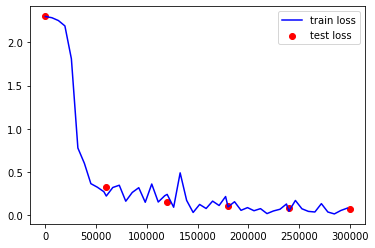

In [ ]:
plt.figure()
plt.plot(train_counter, train_losses, color='blue', label='train loss')
plt.scatter(test_counter, test_losses, color='red', label='test loss')
plt.legend()
plt.show()

Generalmente, si la curva de la funcion de train (azul) con la curva de la funcion de test (rojo) se comienzan a separar es porque hay overfitting.

In [ ]:
with torch.no_grad():
  output = network(exampleData.to(device))

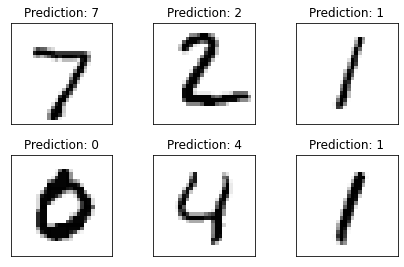

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray_r', interpolation='none')
  #'data.max' es el maximo de las probabilidades que nos ha devuelto la red
  plt.title(f'Prediction: {output.data.max(1, keepdim=True)[1][i].item()}')
  plt.xticks([])
  plt.yticks([])
plt.show()

In [ ]:
# Continuar entrenamiento desde archivos

continued_network = Network()

#cargamos el modelo guardado en archivo 'pth' pytorch
#recuerde que es la estructura del modelo, mas no el modelo entrenado
#hay que volverlo a entrenar pero usando sus pesos
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)
continued_network = continued_network.to(device)

continued_optimizer = optim.SGD(continued_network.parameters(), lr=0.0005, momentum=momentum)
optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(6, 11):
  test_counter.append(i*len(train_loader.dataset))
  train(continued_network, continued_optimizer, i)
  test(continued_network)

Train epoch: 6 [0/60000 (0%)]	Loss: 0.173667
Train epoch: 6 [6400/60000 (11%)]	Loss: 0.103497
Train epoch: 6 [12800/60000 (21%)]	Loss: 0.017205
Train epoch: 6 [19200/60000 (32%)]	Loss: 0.040985
Train epoch: 6 [25600/60000 (43%)]	Loss: 0.041296
Train epoch: 6 [32000/60000 (53%)]	Loss: 0.109289
Train epoch: 6 [38400/60000 (64%)]	Loss: 0.080756
Train epoch: 6 [44800/60000 (75%)]	Loss: 0.057749
Train epoch: 6 [51200/60000 (85%)]	Loss: 0.039901
Train epoch: 6 [57600/60000 (96%)]	Loss: 0.057693

Test set: Avg. Loss: 0.0567, Accuracy: 9829/10000 (98%)

Train epoch: 7 [0/60000 (0%)]	Loss: 0.017841
Train epoch: 7 [6400/60000 (11%)]	Loss: 0.131692
Train epoch: 7 [12800/60000 (21%)]	Loss: 0.034617
Train epoch: 7 [19200/60000 (32%)]	Loss: 0.068227
Train epoch: 7 [25600/60000 (43%)]	Loss: 0.151551
Train epoch: 7 [32000/60000 (53%)]	Loss: 0.023053
Train epoch: 7 [38400/60000 (64%)]	Loss: 0.085260
Train epoch: 7 [44800/60000 (75%)]	Loss: 0.032515
Train epoch: 7 [51200/60000 (85%)]	Loss: 0.043688
Trai

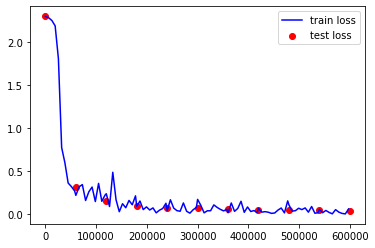

In [ ]:
plt.figure()
plt.plot(train_counter, train_losses, color='blue', label='train loss')
plt.scatter(test_counter, test_losses, color='red', label='test loss')
plt.legend()
plt.show()

# Ejercicio: Implementar un modelo CNN para el dataset FashionMNIST

- Cambiar el diseño de la red
- Cambiar el optimizador
- Incrementar al cantidad de épocas